<a href="https://colab.research.google.com/github/machiwao/pjdsc-optima-prime-sakayan-express/blob/main/SakayanExpress_RouteSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sakayan Express - Route Simulation
Simulate bus routes in historical data. Produce a predictive route simulation based on historical data by suggesting recommended number of buses

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

In [3]:
Belga_0711_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0711_BELGA_withFuelData.csv"
Deocareza_0711_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0711_DEOCAREZA_withFuelData.csv"
Graceda_0711_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0711_GRACEDA_withFuelData.csv"
Manuel_0711_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0711_MANUEL_withFuelData.csv"
Paralde_0711_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0711_PARALDE_withFuelData.csv"

Carmelotes_0712_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0712_CARMELOTES_withFuelData.csv"
Escuerdo_0712_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0712_ESCUERDO_withFuelData.csv"
Graceda_0712_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0712_GRACEDA_withFuelData.csv"
Neri_0712_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0712_NERI_withFuelData.csv"
Ostan_0712_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0712_OSTAN_withFuelData.csv"

Bajaro_0713_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0713_BAJARO.csv"
Escuerdo_0713_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0713_ESCUERDO_withFuelData.csv"
Graceda_0713_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0713_GRACEDA_withFuelData.csv"
Neri_0713_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0713_NERI_withFuelData.csv"
Ostan_0713_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0713_OSTAN_withFuelData.csv"

Belga_0717_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0717_BELGA_withFuelData.csv"
Caralde_0717_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0717_CARALDE_withFuelData.csv"

Arangco_0718_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0718_ARANGCO.csv"
Ceballos_0718_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0718_CEBALLOS.csv"
Delosreyes_0718_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0718_DELOSREYES.csv"
Fontillas_0718_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0718_FONTILLAS_withFuelData.csv"
Lina_0718_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0718_LINA.csv"
Neri_0718_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0718_NERI_withFuelData.csv"

Arango_0719_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0719_ARANGO.csv"
Bolata_0719_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0719_BOLATA.csv"
Gipa_0719_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0719_GIPA.csv"
Loy_0719_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0719_LOY.csv"
Porquez_0719_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0719_PORQUEZ.csv"

Arango_0721_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0721_ARANGO.csv"
Gipa_0721_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0721_GIPA.csv"
Ubusan_0721_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0721_UBUSAN.csv"

Delos_Reyes_0728_url = "https://raw.githubusercontent.com/machiwao/pjdsc-optima-prime-sakayan-express/refs/heads/main/dataset/0728_Delos_Reyes.csv"

In [4]:
df = pd.read_csv(Belga_0711_url)

In [5]:
df.sample(10)

,id,driver,datePH,longitude,latitude,altitude,gpsSpeed,timeStamp,calEngineLoad,vehSpeed,...,Altitude,Accuracy,Hour,Min,Sec,Feedno,Withpass,Withevent,Cumpass,Pass
29901,64acda020e0d0c223db15b84,Roly Belga,20230711,120.988952,14.535140,32,0,2023-07-11T04:26:38.000+0000,40,0,...,48.00,7.32,12.0,26.0,38.0,27536.0,1.0,2.0,38.0,0.0
32002,64ace2029367123265391dfe,Roly Belga,20230711,121.030985,14.551445,30,17,2023-07-11T05:00:49.000+0000,100,19,...,87.85,5.85,13.0,0.0,49.0,29621.0,1.0,2.0,31.0,0.0
51763,64ad2da1348aa917282aadfc,Roly Belga,20230711,120.986900,14.657318,25,0,2023-07-11T10:23:27.000+0000,52,0,...,64.70,10.64,18.0,23.0,27.0,46567.0,1.0,2.0,67.0,0.0
38157,64acf98cdaa2b1535bd3b8ae,Roly Belga,20230711,121.038550,14.642440,43,40,2023-07-11T06:41:15.000+0000,0,39,...,84.60,11.17,14.0,41.0,15.0,35060.0,1.0,2.0,35.0,0.0
7524,64ac7fea75e54923c04a02dc,Roly Belga,20230711,121.011843,14.657465,43,0,2023-07-10T22:01:47.000+0000,37,0,...,63.70,3.90,6.0,1.0,47.0,7670.0,1.0,1.0,43.0,1.0
10255,64ac8a0c38f59333b789f22f,Roly Belga,20230711,121.032963,14.553462,23,30,2023-07-10T22:45:30.000+0000,0,29,...,65.90,3.90,6.0,45.0,30.0,10394.0,1.0,2.0,33.0,0.0
7567,64ac7ff975e54923c04a033a,Roly Belga,20230711,121.013818,14.657482,33,34,2023-07-10T22:02:27.000+0000,0,33,...,60.20,3.90,6.0,2.0,27.0,7713.0,1.0,2.0,45.0,0.0
26050,64acc5c97748f5110d87c538,Roly Belga,20230711,121.028243,14.550242,0,0,2023-07-11T02:59:47.000+0000,84,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51908,64ad2e15348aa917282ab01f,Roly Belga,20230711,120.986362,14.657277,26,0,2023-07-11T10:25:24.000+0000,47,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55321,64ad3b216a27bb2d447ca52e,Roly Belga,20230711,121.048447,14.624912,65,36,2023-07-11T11:21:04.000+0000,0,37,...,81.30,15.00,19.0,21.0,4.0,49621.0,1.0,2.0,62.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59962 entries, 0 to 59961
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   59962 non-null  object 
 1   driver               59962 non-null  object 
 2   datePH               59962 non-null  int64  
 3   longitude            59962 non-null  float64
 4   latitude             59962 non-null  float64
 5   altitude             59962 non-null  int64  
 6   gpsSpeed             59962 non-null  int64  
 7   timeStamp            59962 non-null  object 
 8   calEngineLoad        59962 non-null  int64  
 9   vehSpeed             59962 non-null  int64  
 10  throttlePosition     59962 non-null  int64  
 11  ambientAirTemp       59962 non-null  int64  
 12  engineOilTemp        59962 non-null  int64  
 13  Speed                59962 non-null  int64  
 14  fuelPressure         59962 non-null  int64  
 15  engineRPM            59962 non-null 

In [7]:
df.describe()

,datePH,longitude,latitude,altitude,gpsSpeed,calEngineLoad,vehSpeed,throttlePosition,ambientAirTemp,engineOilTemp,...,Altitude,Accuracy,Hour,Min,Sec,Feedno,Withpass,Withevent,Cumpass,Pass
count,59962.0,59962.000000,59962.000000,59962.000000,59962.000000,59962.000000,59962.000000,59962.000000,59962.000000,59962.000000,...,53385.000000,53385.000000,53385.000000,53385.000000,53385.000000,53385.000000,53385.000000,53385.000000,53385.000000,53385.000000
mean,20230711.0,121.015852,14.582620,31.943781,12.439695,40.623378,13.531353,16.221574,31.234882,91.116074,...,68.544674,7.283566,11.684256,29.035984,29.508439,27089.408954,1.032799,1.976042,38.653255,0.000468
std,0.0,0.024735,0.054249,18.870216,16.248403,22.730954,16.755636,26.054464,2.799451,2.627240,...,18.453354,8.305447,4.872378,16.987965,17.326651,15347.426785,0.178113,0.152920,16.971604,0.154785
min,20230711.0,120.983452,14.507295,-157.000000,0.000000,0.000000,0.000000,0.000000,27.000000,86.000000,...,-168.810000,2.150000,4.000000,0.000000,0.000000,532.000000,1.000000,1.000000,7.000000,-1.000000
25%,20230711.0,120.991318,14.537463,18.000000,0.000000,31.000000,0.000000,0.000000,29.000000,89.000000,...,55.800000,3.900000,8.000000,15.000000,15.000000,13775.000000,1.000000,2.000000,26.000000,0.000000
50%,20230711.0,121.009363,14.564530,31.000000,0.000000,41.000000,4.000000,0.000000,31.000000,91.000000,...,65.500000,4.250000,12.000000,29.000000,30.000000,27057.000000,1.000000,2.000000,35.000000,0.000000
75%,20230711.0,121.039225,14.644352,46.000000,27.000000,51.000000,28.000000,30.000000,34.000000,93.000000,...,81.000000,9.030000,16.000000,44.000000,45.000000,40396.000000,1.000000,2.000000,53.000000,0.000000
max,20230711.0,121.059888,14.657928,120.000000,62.000000,100.000000,65.000000,100.000000,39.000000,100.000000,...,309.660000,335.900000,20.000000,59.000000,59.000000,53641.000000,2.000000,2.000000,85.000000,1.000000


In [8]:
df.isna().sum()

,0
id,0
driver,0
datePH,0
longitude,0
latitude,0
altitude,0
gpsSpeed,0
timeStamp,0
calEngineLoad,0
vehSpeed,0


In [9]:
df.duplicated().sum()

0

## Defining Initial Parameters

In [10]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define initial parameters
n_buses = 10  # Number of buses
n_stops = 20  # Number of stops in the route
bus_capacity = 50  # Maximum passengers per bus
initial_passengers = [random.randint(10, 30) for _ in range(n_buses)]  # Initial passengers on each bus

# Generate random demand for passengers at each stop
passenger_demand = [random.randint(5, 20) for _ in range(n_stops)]
alight_prob = 0.3  # Probability a passenger will alight at a stop


## Define function simulating boarding and alighting

In [11]:
# Step 2: Define a function to simulate boarding and alighting
def update_passengers(current_passengers, demand, bus_capacity):
    # Simulate passengers alighting
    alight = int(current_passengers * alight_prob)
    current_passengers -= alight

    # Simulate new passengers boarding
    boarding = min(demand, bus_capacity - current_passengers)
    current_passengers += boarding

    return current_passengers, alight, boarding

## Bus Simulation

In [12]:
# Step 3: Simulate the bus route
bus_utilization = []

for stop in range(n_stops):
    print(f"Stop {stop + 1}:")
    for bus in range(n_buses):
        demand = passenger_demand[stop]
        current_passengers, alight, boarding = update_passengers(initial_passengers[bus], demand, bus_capacity)
        initial_passengers[bus] = current_passengers
        utilization = (current_passengers / bus_capacity) * 100
        bus_utilization.append(utilization)

        print(f"Bus {bus + 1} - Passengers: {current_passengers} (Alight: {alight}, Boarding: {boarding})")
        print(f"Bus {bus + 1} Utilization: {utilization:.2f}%")
    print("------")

Stop 1:
Bus 1 - Passengers: 41 (Alight: 9, Boarding: 20)
Bus 1 Utilization: 82.00%
Bus 2 - Passengers: 34 (Alight: 5, Boarding: 20)
Bus 2 Utilization: 68.00%
Bus 3 - Passengers: 34 (Alight: 5, Boarding: 20)
Bus 3 Utilization: 68.00%
Bus 4 - Passengers: 29 (Alight: 3, Boarding: 20)
Bus 4 Utilization: 58.00%
Bus 5 - Passengers: 28 (Alight: 3, Boarding: 20)
Bus 5 Utilization: 56.00%
Bus 6 - Passengers: 41 (Alight: 8, Boarding: 20)
Bus 6 Utilization: 82.00%
Bus 7 - Passengers: 27 (Alight: 3, Boarding: 20)
Bus 7 Utilization: 54.00%
Bus 8 - Passengers: 37 (Alight: 6, Boarding: 20)
Bus 8 Utilization: 74.00%
Bus 9 - Passengers: 31 (Alight: 4, Boarding: 20)
Bus 9 Utilization: 62.00%
Bus 10 - Passengers: 29 (Alight: 3, Boarding: 20)
Bus 10 Utilization: 58.00%
------
Stop 2:
Bus 1 - Passengers: 39 (Alight: 12, Boarding: 10)
Bus 1 Utilization: 78.00%
Bus 2 - Passengers: 34 (Alight: 10, Boarding: 10)
Bus 2 Utilization: 68.00%
Bus 3 - Passengers: 34 (Alight: 10, Boarding: 10)
Bus 3 Utilization: 68.0

## Simulation Summary

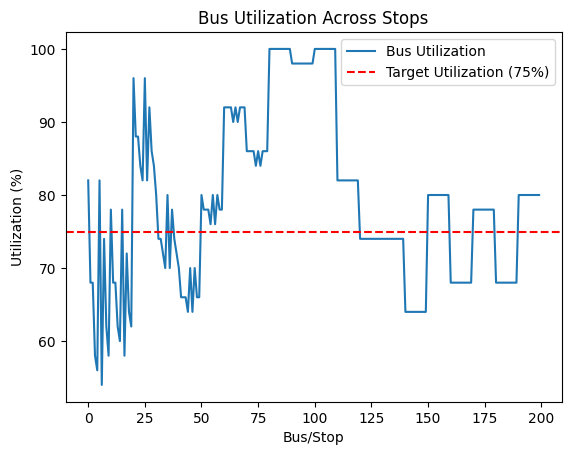

In [13]:
# Step 4: Visualization (Optional)
# Plotting the utilization of buses across the route
plt.plot(bus_utilization, label="Bus Utilization")
plt.axhline(y=75, color='r', linestyle='--', label="Target Utilization (75%)")
plt.title("Bus Utilization Across Stops")
plt.xlabel("Bus/Stop")
plt.ylabel("Utilization (%)")
plt.legend()
plt.show()